# Tree model的演变过程
* 决策树
    * 分类树
    * 回归树
* GBDT(Gradient Boosting Decison Tree)
* XGBoost
* CatBoost

## 树模型的优势（From陈天奇PPT
* Invariant to scaling of inputs, so you do not need to do careful features normalization. From陈天奇PPT  
不受输入缩放的影响，因此不需要对特性进行细致的标准化。
* Learn higher order interaction between features.
* Can be scalable, and are used in Industry

## GBDT
http://www.360doc.com/content/18/0101/17/40769523_718161675.shtml

GBDT（Gradient Boosting Decison Tree）中的树都是回归树，GBDT用来做回归预测，调整后也可以用于分类（设定阈值，大于阈值为正例，反之为负例），可以发现多种有区分性的特征以及特征组合。

GBDT是把所有树的结论累加起来做最终结论的，GBDT的核心就在于，每一棵树学的是之前所有树结论和的残差(负梯度)，这个残差就是一个加预测值后能得真实值的累加量。比如A的真实年龄是18岁，但第一棵树的预测年龄是12岁，差了6岁，即残差为6岁。那么在第二棵树里我们把A的年龄设为6岁去学习，如果第二棵树真的能把A分到6岁的叶子节点，那累加两棵树的结论就是A的真实年龄；如果第二棵树的结论是5岁，则A仍然存在1岁的残差，第三棵树里A的年龄就变成1岁，继续学。 

__Boosting的最大好处在于，每一步的残差计算其实变相地增大了分错instance的权重，而已经分对的instance则都趋向于0__。这样后面的树就能越来越专注那些前面被分错的instance。

### AdaBoost原理

原始的AdaBoost算法是在算法开始的时候，为每一个样本赋上一个权重值，初始的时候，大家都是一样重要的。在每一步训练中得到的模型，会使得数据点的估计有对有错，我们就在每一步结束后，增加分错的点的权重，减少分对的点的权重，这样使得某些点如果老是被分错，那么就会被“重点关注”，也就被赋上一个很高的权重。然后等进行了N次迭代（由用户指定），将会得到N个简单的分类器（basic learner），然后我们将它们组合起来（比如说可以对它们进行加权、或者让它们进行投票等），得到一个最终的模型。

### Gradient Boost与AdaBoost的区别

Gradient Boost每一次的计算是为了减少上一次的残差(residual)，而为了消除残差，我们可以在残差减少的梯度(Gradient)方向上建立一个新的模型。所以说，在Gradient Boost中，每个新的模型的建立是为了使得之前模型的残差往梯度方向减少。
#### Shrinkage
Shrinkage（缩减）的思想认为，每次走一小步逐渐逼近结果的效果，要比每次迈一大步很快逼近结果的方式更容易避免过拟合。即它不完全信任每一个棵残差树，它认为每棵树只学到了真理的一小部分，累加的时候只累加一小部分，通过多学几棵树弥补不足。本质上，Shrinkage为每棵树设置了一个weight，累加时要乘以这个weight，但和Gradient并没有关系。

Adaboost是另一种boost方法，它按分类对错，分配不同的weight，计算cost function时使用这些weight，从而让“错分的样本权重越来越大，使它们更被重视”

## Gradient Boost优缺点

优点：它的非线性变换比较多，表达能力强，而且不需要做复杂的特征工程和特征变换。

缺点: Boost是一个串行过程，不好并行化，而且计算复杂度高，同时不太适合高维稀疏特征。

## XGBoost

XGBoost能自动利用cpu的多线程，而且适当改进了gradient boosting，加了剪枝，控制了模型的复杂程度

传统GBDT以CART作为基分类器，特指梯度提升决策树算法，而XGBoost还支持线性分类器(gblinear)，这个时候XGBoost相当于带L1和L2正则化项的逻辑斯蒂回归（分类问题）或者线性回归（回归问题）。

传统GBDT在优化时只用到一阶导数信息，xgboost则对代价函数进行了二阶泰勒展开，同时用到了一阶和二阶导数。

xgboost工具支持自定义代价函数，只要函数可一阶和二阶求导。

xgboost在代价函数里加入了正则项，用于控制模型的复杂度。正则项里包含了树的叶子节点个数、每个叶子节点上输出的score的L2模的平方和。从Bias-variance trade off角度来讲，正则项降低了模型的variance，使学习出来的模型更加简单，防止过拟合，这也是xgboost优于传统GBDT的一个特性。
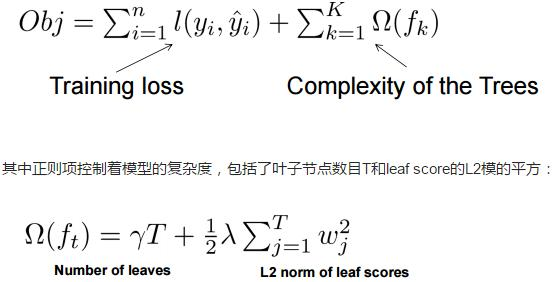

### xgboost的特点
xgboost中树节点分裂时所采用的公式：
#### xgboost中的eta
传统GBDT的Shrinkage（缩减），相当于学习速率（xgboost中的eta）。xgboost在进行完一次迭代后，会将叶子节点的权重乘上该系数，主要是为了削弱每棵树的影响，让后面有更大的学习空间。实际应用中，一般把eta设置得小一点，然后迭代次数设置得大一点。（传统GBDT的实现也有学习速率）

#### 列抽样（column subsampling）
xgboost借鉴了随机森林的做法，支持列抽样，不仅能降低过拟合，还能减少计算，这也是xgboost异于传统gbdt的一个特性。

#### 对缺失值的处理。
对于特征的值有缺失的样本，xgboost可以自动学习出它的分裂方向。

#### xgboost工具支持并行
注意xgboost的并行不是tree粒度的并行，xgboost也是一次迭代完才能进行下一次迭代的（第t次迭代的代价函数里包含了前面t-1次迭代的预测值）。xgboost的并行是在特征粒度上的。

我们知道，决策树的学习最耗时的一个步骤就是对特征的值进行排序（因为要确定最佳分割点），xgboost在训练之前，预先对数据进行了排序，然后保存为block结构，后面的迭代中重复地使用这个结构，大大减小计算量。这个block结构也使得并行成为了可能，在进行节点的分裂时，需要计算每个特征的增益，最终选增益最大的那个特征去做分裂，那么各个特征的增益计算就可以开多线程进行。(特征粒度上的并行，block结构，预排序)
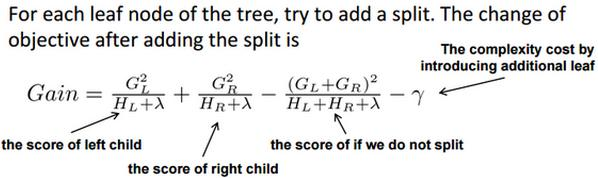

这个公式形式上跟ID3算法、CART算法是一致的，都是用分裂后的某种值减去分裂前的某种值，从而得到增益。为了限制树的生长，我们可以加入阈值，当增益大于阈值时才让节点分裂，上式中的gamma即阈值，它是正则项里叶子节点数T的系数，所以xgboost在优化目标函数的同时相当于做了预剪枝。

另外，上式中还有一个系数lambda，是正则项里leaf score的L2模平方的系数，对leaf score做了平滑，也起到了防止过拟合的作用，这个是传统GBDT里不具备的特性。

### XGBoost实现层面

#### 内置交叉验证方法

    能够输出特征重要性文件辅助特征筛选

XGBoost优势小结：

    显式地将树模型的复杂度作为正则项加在优化目标

    公式推导里用到了二阶导数信息，而普通的GBDT只用到一阶

    允许使用列抽样(column(feature) sampling)来防止过拟合，借鉴了Random Forest的思想，sklearn里的gbm好像也有类似实现。

    实现了一种分裂节点寻找的近似算法，用于加速和减小内存消耗。

    节点分裂算法能自动利用特征的稀疏性。

    样本数据事先排好序并以block的形式存储，利于并行计算

    penalty function Omega主要是对树的叶子数和叶子分数做惩罚，这点确保了树的简单性。

    支持分布式计算可以运行在MPI，YARN上，得益于底层支持容错的分布式通信框架rabit。

## LightGBM

lightGBM：基于决策树算法的分布式梯度提升框架。

### lightGBM与XGBoost的区别：

#### 切分算法(切分点的选取)

    占用的内存更低，只保存特征离散化后的值，而这个值一般用8位整型存储就足够了，内存消耗可以降低为原来的1/8。

    降低了计算的代价：预排序算法每遍历一个特征值就需要计算一次分裂的增益，而直方图算法只需要计算k次（k可以认为是常数），时间复杂度从O(#data#feature)优化到O(k#features)。(相当于LightGBM牺牲了一部分切分的精确性来提高切分的效率，实际应用中效果还不错)

    空间消耗大，需要保存数据的特征值以及特征排序的结果(比如排序后的索引，为了后续快速计算分割点)，需要消耗两倍于训练数据的内存

    时间上也有较大开销，遍历每个分割点时都需要进行分裂增益的计算，消耗代价大

    对cache优化不友好，在预排序后，特征对梯度的访问是一种随机访问，并且不同的特征访问的顺序不一样，无法对cache进行优化。同时，在每一层长树的时候，需要随机访问一个行索引到叶子索引的数组，并且不同特征访问的顺序也不一样，也会造成较大的cache miss。

    XGBoost使用的是pre-sorted算法
    （对所有特征都按照特征的数值进行预排序，基本思想是对所有特征都按照特征的数值进行预排序；然后在遍历分割点的时候用O(#data)的代价找到一个特征上的最好分割点最后，找到一个特征的分割点后，将数据分裂成左右子节点。优点是能够更精确的找到数据分隔点；但这种做法有以下缺点

    LightGBM使用的是histogram算法，
    基本思想是先把连续的浮点特征值离散化成k个整数，同时构造一个宽度为k的直方图。在遍历数据的时候，根据离散化后的值作为索引在直方图中累积统计量，当遍历一次数据后，直方图累积了需要的统计量，然后根据直方图的离散值，遍历寻找最优的分割点；优点在于

#### 决策树生长策略上：

    XGBoost采用的是带深度限制的level-wise生长策略，Level-wise过一次数据可以能够同时分裂同一层的叶子，容易进行多线程优化，不容易过拟合；但不加区分的对待同一层的叶子，带来了很多没必要的开销（因为实际上很多叶子的分裂增益较低，没必要进行搜索和分裂）

    LightGBM采用leaf-wise生长策略，每次从当前所有叶子中找到分裂增益最大（一般也是数据量最大）的一个叶子，然后分裂，如此循环；但会生长出比较深的决策树，产生过拟合（因此 LightGBM 在leaf-wise之上增加了一个最大深度的限制，在保证高效率的同时防止过拟合）。
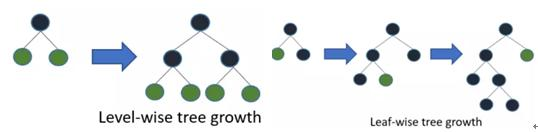

    histogram 做差加速。一个容易观察到的现象：一个叶子的直方图可以由它的父亲节点的直方图与它兄弟的直方图做差得到。通常构造直方图，需要遍历该叶子上的所有数据，但直方图做差仅需遍历直方图的k个桶。利用这个方法，LightGBM可以在构造一个叶子的直方图后，可以用非常微小的代价得到它兄弟叶子的直方图，在速度上可以提升一倍。

    直接支持类别特征：LightGBM优化了对类别特征的支持，可以直接输入类别特征，不需要额外的0/1展开。并在决策树算法上增加了类别特征的决策规则。

    分布式训练方法上(并行优化)

    在特征并行算法中，通过在本地保存全部数据避免对数据切分结果的通信；

    在数据并行中使用分散规约(Reduce scatter)把直方图合并的任务分摊到不同的机器，降低通信和计算，并利用直方图做差，进一步减少了一半的通信量。基于投票的数据并行(Parallel Voting)则进一步优化数据并行中的通信代价，使通信代价变成常数级别。

    特征并行的主要思想是在不同机器在不同的特征集合上分别寻找最优的分割点，然后在机器间同步最优的分割点。

    数据并行则是让不同的机器先在本地构造直方图，然后进行全局的合并，最后在合并的直方图上面寻找最优分割点。

    原始

    LightGBM针对这两种并行方法都做了优化，

    Cache命中率优化

    基于直方图的稀疏特征优化

    DART(Dropout + GBDT)

    GOSS(Gradient-based One-Side Sampling):一种新的Bagging(row subsample)方法,前若干轮(1.0f / gbdtconfig->learning_rate)不Bagging;之后Bagging时, 采样一定比例g(梯度)大的样本

LightGBM优点小结(相较于XGBoost)

    速度更快

    内存消耗更低

# 代码实现

## 回归树regression_tree
https://mp.weixin.qq.com/s?__biz=MzAxMjUyNDQ5OA==&mid=2653557207&idx=1&sn=65d635e4b2b2d514c5cf472317001f2d&chksm=806e3f6ab719b67c01d1891eaf4524e8318983481cfbc6cefe555156d6858e02f8ffeb12b859&scene=21#wechat_redirect

### 原理篇

我们用人话而不是大段的数学公式，来讲讲回归树是怎么一回事。
1.1 最简单的模型

如果预测某个连续变量的大小，最简单的模型之一就是用平均值。比如同事的平均年龄是 28 岁，那么新来了一批同事，在不知道这些同事的任何信息的情况下，直觉上用平均值 28 来预测是比较准确的，至少比 0 岁或者 100 岁要靠谱一些。

1.2 加一点难度

仍然是预测同事年龄，这次我们预先知道了同事的职级，假设职级的范围是整数1-10，如何能让这个信息帮助我们更加准确的预测年龄呢？

一个思路是根据职级把同事分为两组，这两组分别应用我们之前提到的“平均值”模型。比如职级小于 5 的同事分到A组，大于或等于5的分到 B 组，A 组的平均年龄是 25 岁，B 组的平均年龄是 35 岁。如果新来了一个同事，职级是 3，应该被分到 A 组，我们就预测他的年龄是 25 岁。

1.3 最佳分割点

还有一个问题待解决，如何取一个最佳的分割点对不同职级的同事进行分组呢？

我们尝试所有 m 个可能的分割点 P_i，沿用之前的损失函数，对 A、B 两组分别计算 Loss 并相加得到 L_i。最小的 L_i 所对应的 P_i 就是我们要找的“最佳分割点”。

1.4 运用多个变量

再复杂一些，如果我们不仅仅知道了同事的职级，还知道了同事的工资（貌似不科学），该如何预测同事的年龄呢？

我们可以分别根据职级、工资计算出职级和工资的最佳分割点P_1, P_2，对应的Loss L_1, L_2。然后比较L_1和L2，取较小者。假设L_1 < L_2，那么按照P_1把不同职级的同事分为A、B两组。在A、B组内分别计算工资所对应的分割点，再分为C、D两组。这样我们就得到了AC, AD, BC, BD四组同事以及对应的平均年龄用于预测。

### 抽象
第一步，对于某个节点，属于该点的所有node的值的均值作为该点的预测值

第二步，node分裂

选择哪个特征分裂？

确定了特征以后，在该特征的哪个分裂点分裂？

定义loss function: 均方差$$L=\frac{1}{2}\sum^m_{i=0}(y_i-y)^2$$

选择使得loss最小的特征的分裂点进行分裂

第三步，迭代

第四步，终止条件？

max_depth=5, min_samples_split=2

In [1]:
from decision_trees import _DecisionTreeBase

In [2]:
import shap  #SHAP package

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
X, y = shap.datasets.boston()

In [4]:
t = _DecisionTreeBase()

In [5]:
t._rules

In [6]:
t.fit(X.values, y)

5


In [8]:
t.print_tree()

5:6.943? 
 T->12:14.43? 
  T->7:1.413? 
    T->0:11.9511? 
        T->50.0
        F->27.9
    F->5:6.546? 
        T->21.62974358974359
        F->27.427272727272722
  F->0:7.02259? 
    T->4:0.538? 
        T->20.020833333333332
        F->16.238961038961037
    F->4:0.614? 
        T->16.633333333333333
        F->11.077419354838709
 F->5:7.454? 
  T->0:8.24809? 
    T->7:1.8946? 
        T->45.65
        F->32.74878048780488
    F->0:88.9762? 
        T->16.4
        F->10.4
  F->0:3.47428? 
    T->10:14.9? 
        T->48.300000000000004
        F->43.653333333333336
    F->21.9


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
mean_squared_error(y, t.predict(X.values))

9.64580850677113

In [11]:
r2_score(y, t.predict(X.values))

0.8857396443908376

## GBDT
https://mp.weixin.qq.com/s?__biz=MzAxMjUyNDQ5OA==&mid=2653557219&idx=1&sn=523502247d6a7c5f0a4c795a31dc0f47&chksm=806e3f5eb719b64850348792bc8ac680ae2632eb71699779d1cb54230a278980d8c843128438&scene=21#wechat_redirect

https://zhuanlan.zhihu.com/p/32181306

### 原理篇
1.2 预测年龄
仍然以预测同事年龄来举例，从《回归树》那篇文章中我们可以知道，如果需要通过一个常量来预测同事的年龄，平均值是最佳选择之一。

1.3 年龄的残差
我们不妨假设同事的年龄分别为5岁、6岁、7岁，那么同事的平均年龄就是6岁。所以我们用6岁这个常量来预测同事的年龄，即[6, 6, 6]。每个同事年龄的残差 = 年龄 - 预测值 = [5, 6, 7] - [6, 6, 6]，所以残差为[-1, 0, 1]

1.4 预测年龄的残差
为了让模型更加准确，其中一个思路是让残差变小。如何减少残差呢？我们不妨对残差建立一颗回归树，然后预测出准确的残差。假设这棵树预测的残差是[-0.9, 0, 0.9]，将上一轮的预测值和这一轮的预测值求和，每个同事的年龄 = [6, 6, 6] + [-0.9, 0, 0.9] = [5.1, 6, 6.9]，显然与真实值[5, 6, 7]更加接近了， 年龄的残差此时变为[-0.1, 0, 0.1]，预测的准确性得到了提升。

1.5 GBDT
重新整理一下思路，假设我们的预测一共迭代3轮 年龄：[5, 6, 7]

第1轮预测：6, 6, 6

第1轮残差：[-1, 0, 1]

第2轮预测：6, 6, 6 + -0.9, 0, 0.9 = [5.1, 6, 6.9]

第2轮残差：[-0.1, 0, 0.1]

第3轮预测：6, 6, 6 + -0.9, 0, 0.9 + -0.08, 0, 0.07 = [5.02, 6, 6.97]

第3轮残差：[-0.08, 0, 0.03]

看上去残差越来越小，而这种预测方式就是GBDT算法。

1.6 公式推导
看到这里，相信您对GBDT已经有了直观的认识。这么做有什么科学依据么，为什么残差可以越来越小呢？前方小段数学公式低能预警。

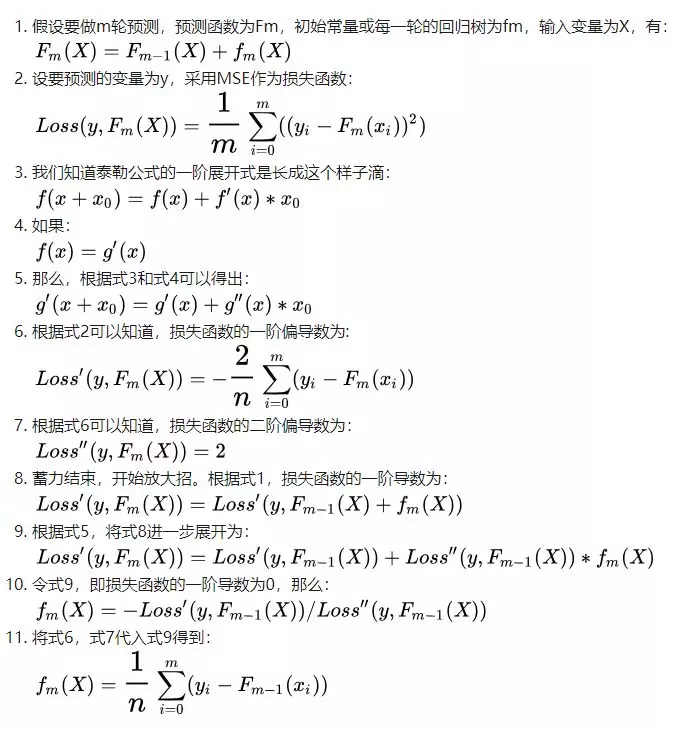

因此，我们需要通过用第m-1轮残差的均值来得到函数fm，进而优化函数Fm。而回归树的原理就是通过最佳划分区域的均值来进行预测。所以fm可以选用回归树作为基础模型，将初始值，m-1颗回归树的预测值相加便可以预测y。

In [1]:
import sys
sys.path.append('..')

In [3]:
from gbdt import GBDTRegressor

In [4]:
g = GBDTRegressor()

In [6]:
import shap  #SHAP package

In [7]:
X, y = shap.datasets.boston()

In [8]:
g.fit(X.values, y)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

In [10]:
mean_squared_error(y, g.predict(X.values))

0.006486940658134635

In [11]:
r2_score(y, g.predict(X.values))

0.9999231583183624

## XGBoost
https://zhuanlan.zhihu.com/p/32181687

https://blog.csdn.net/u012535605/article/details/80078903

https://xgboost.apachecn.org/#/docs/3

好好看看陈天奇的ppt

### 目标函数(objective)构成

目标函数一般由两部分组成：训练损失和正则化项

1.training loss:度量模型对训练数据集的拟合程度，常见有平方误差和逻辑损失

2.正则化项：度量模型的复杂程度，常见有L2和L1范式，

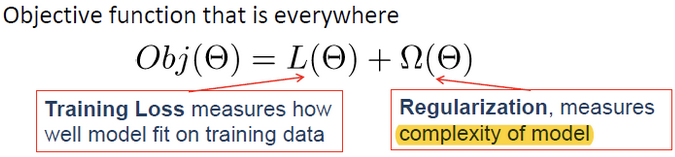

### Model-我们要学习的成果是什么
    regression tree is a function that maps the attributes to the score
* Model: assuming we have K trees
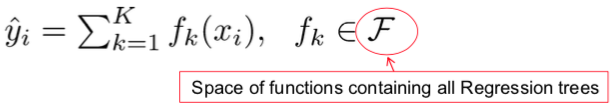

### Parameters-待学习的参数
对于每一颗regression tree而言，我们要搞清楚两件事情：  
从哪个特征分类？找到该特征的最佳分裂点。  
做法是：遍历所有特征，找到每个特征的最佳分裂点，然后再比较每个特征的最佳分裂点得分，找出最佳分裂点得分对应的特征。！

* Including structure of each tree, and the score in the leaf，Or simply use function as parameters
$$\theta=\{f_1, f_2,...., f_K\}$$
* Instead learning weights in $R^d$, we are learning functions(trees)

### Learning a step function(阶跃函数)
Things we need to learn
* Splitting Positions
* The Height in each segment
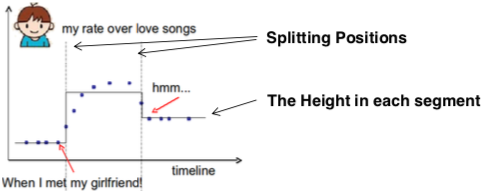

### Regression Tree is not just for regression!
* it can be used for Classification, Regression, Ranking....
* It all depends on how you define the objective function!
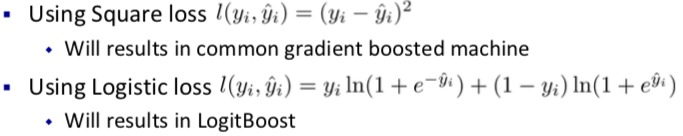

### 符号释义
$t: 迭代次数$

$n: 样本总数$

$m: 特征总数$

$i: 第i个样本的索引$

$x_i: 第i个样本$

$y_i: 第i个样本true value$

$y^{\^}_i: 第i个样本predict value$

$f_t: 第t步的树$



$y^{^t}_i$